# Introduction to Deep Learning Lab!#

In class we learned about the building blocks of neural networks: *Linear Units*. We saw that a model of just one linear unit will fit a linear function to a dataset (equivalent to linear regression). 

In the lab exercises today, you will:

1.   Build a linear model with **a single neuron** and get some practice working with models in Keras
2.   Combine single neurons in layers and add activation functions to create **deep neural networks** to model more complex relationships
3.   Train a neural network using **stochastic gradient descent** and see how neural networks learn

Before you get started, run the code cells below to set everything up.

## Setting Up the Workspace

In [ ]:
#!pip install sklearn
import sklearn
sklearn.__version__

'1.2.2'

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn import set_config
from IPython.display import display

from sklearn.linear_model import LinearRegression
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation



In [ ]:
# Setup plotting
plt.style.use('seaborn-whitegrid')

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

<ipython-input-3-e8fedecc2a49>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Loading the Data

We will use the *BigMart* data again with the sales per SKU and per store. In the next few cells we will load the data and use the pipeline to preprocess the data. Just like we did in class before.

In [ ]:
#import pandas as pd
#import numpy as np

df_sales = pd.read_csv('https://www.dropbox.com/s/yqaymhdf7bvvair/bigmart_sales_predictions.csv?dl=1')
df_sales.head(5)

#Remove columns we will not use today
df_sales = df_sales.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'])

#Normalize ItemFatContent
df_sales['Item_Fat_Content'] = df_sales['Item_Fat_Content'].replace(
    {'Low Fat': 0,
     'LF': 0,
     'low fat': 0,
     'Regular': 1,
     'reg': 1})
df_sales['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

## Pre-processing Pipeline

In [ ]:
#from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
#from sklearn.compose import make_column_transformer, make_column_selector
#from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import train_test_split
#from sklearn.impute import SimpleImputer
#from sklearn import set_config
#from sklearn.pipeline import Pipeline

#Establish each pipeline for differente feature types
categorical_features = ['Item_Type','Outlet_Location_Type','Outlet_Type']
cat_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

categorical_ordinal_features = ['Outlet_Size']
cat_ord_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehotencoder', OrdinalEncoder(handle_unknown='error',
                                     categories=[['Missing','Small','Medium','High']]))])

num_features = ['Item_Weight','Item_Fat_Content','Item_MRP']
num_pipe = Pipeline(steps=[
    ('simpleimputer', SimpleImputer()),
    ('standardscaler', MinMaxScaler())])

#Create rail switch to correctly route each column to the correct pipel
preprocessor = make_column_transformer(
    (cat_pipe, categorical_features),
    (cat_ord_pipe, categorical_ordinal_features),
    (num_pipe, num_features), verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Type', 'Outlet_Location_Type',
                                  'Outlet_Type']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OrdinalEncoder(categories=[['Missing',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']]))]),
                                 ['Outlet_Size']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  MinMaxScaler())]),
                                 ['Item_Weight', 'Item_Fat_Content',
                                  'Item_MRP'])],
                  verbose_feature_names_out=False)

## Define Target, Features and Train-test Split

In [ ]:
target = "Item_Outlet_Sales"
y = df_sales[target].copy()
X = df_sales.drop(columns=[target]).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) #default is 80/20
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
7477,8.365,0,0.120256,Hard Drinks,39.2506,NaN,Tier 3,Grocery Store
5089,13.650,0,0.015944,Breads,231.9668,NaN,Tier 2,Supermarket Type1
6992,14.300,1,0.000000,Fruits and Vegetables,89.8856,Medium,Tier 3,Supermarket Type2


In [ ]:
#We first need to fit each step in our pipeline to the training data.
preprocessor.fit(X_train)

#Now we can transform our data, with the steps specified in the pipeline
Xprocessed_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
Xprocessed_test_df = pd.DataFrame(preprocessor.transform(X_test),
                                  columns=preprocessor.get_feature_names_out(),
                                  index=X_test.index)
display(Xprocessed_train_df)

,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,...,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Item_Weight,Item_Fat_Content,Item_MRP
7477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.226853,0.0,0.033789
5089,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.541530,0.0,0.851775
6992,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.580232,1.0,0.248710
6264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.464126,0.0,0.014990
4374,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.108663,0.0,0.622858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.836261,0.0,0.548958
7763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.494984,0.0,0.020072
5218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.081274,1.0,0.080982
1346,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.657636,0.0,0.341956


You can get the number of rows and columns of a dataframe (or a Numpy array) with the `shape` attribute.

In [ ]:
Xprocessed_train_df.shape # (rows, columns)

(6392, 27)

---
# Lab Exercise 1. *Define a Linear Model*

## 1) Declare Input Shape 

How well can we predict the sales of a SKU at a certain store?

The target is `'Item_Outlet_Sales'`, and the remaining 27 columns are the features. How would you set the `input_shape` parameter for a Keras model on this task?

*Tip!* Remember to only count the input features when determining input_shape. You should not count the target (`'Item_Outlet_Sales'`).

In [ ]:
# YOUR CODE HERE: Fill in the blank
input_shape = [27] # list is required

## 2) Define a Linear Model

Now define a linear model appropriate for this task. Pay attention to how many inputs and outputs the model should have.

In [ ]:
# YOUR CODE HERE: Fill in the blank

model = keras.Sequential([
    layers.Dense(units=1, input_shape = input_shape) #units is the output
])

## 3) Inspect Weights

Internally, Keras represents the weights of a neural network with **tensors**. Tensors are basically TensorFlow's version of a Numpy array with a few differences that make them better suited to deep learning. 

A model's weights are kept in its `weights` attribute as a list of tensors. Get the weights of the model you defined above. You can display the weights with a statement like this: `print("Weights\n{}\n\nBias\n{}".format(w, b))`).

*Tip!* You can get the attribute of an object using the 'dot' notation like this: `object.attribute`. 



In [ ]:
# YOUR CODE HERE: Fill in the blank
w, b = model.weights

print("Weights\n{}\n\nBias\n{}".format(w, b))

Weights
<tf.Variable 'dense/kernel:0' shape=(27, 1) dtype=float32, numpy=
array([[-0.43370083],
       [-0.20268407],
       [-0.14849716],
       [-0.39235485],
       [-0.4012816 ],
       [ 0.41819876],
       [ 0.4267087 ],
       [-0.03826988],
       [-0.08030996],
       [ 0.0312658 ],
       [-0.26619825],
       [ 0.12665302],
       [ 0.35902673],
       [-0.31044245],
       [ 0.3613643 ],
       [-0.37753505],
       [-0.22051264],
       [ 0.26680237],
       [ 0.10989982],
       [-0.11154893],
       [ 0.05526561],
       [-0.10811964],
       [-0.45480785],
       [ 0.13502717],
       [ 0.19116879],
       [ 0.21756828],
       [ 0.11949289]], dtype=float32)>

Bias
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


Keras represents weights as tensors, but also uses tensors to represent data. When you set the `input_shape` argument, you are telling Keras the dimensions of the array it should expect for each example in the training data.

Before the model is trained, the weights are set to random numbers (and the bias to 0.0). A neural network learns by finding better values for its weights.

---
# Lab Exercise 2. *Create a Deep Neural Network*

In class, we saw how to build deep neural networks by stacking layers inside a `Sequential` model. By adding an *activation function* after the hidden layers, we gave the network the ability to learn more complex (non-linear) relationships in the data.

In this exercise, you'll build a neural network with several hidden layers and then explore some activation functions beyond ReLU. 

## 1) Define a Model with Hidden Layers 

Create a model with three hidden layers, each having 512 units and the ReLU activation.  Be sure to include an output layer of one unit and no activation, and also `input_shape` as an argument to the first layer.

In [ ]:
# YOUR CODE HERE: Fill in the blank
model = keras.Sequential([
    layers.Dense(units=512, activation ='relu', input_shape = input_shape),
    layers.Dense(units=512, activation ='relu'),
    layers.Dense(units=512, activation ='relu'),
    layers.Dense(units=1),
])

## 2) Explore Activation Layers 

Let's explore activations functions!

The usual way of attaching an activation function to a `Dense` layer is to include it as part of the definition with the `activation` argument. Sometimes though you'll want to put some other layer between the `Dense` layer and its activation function. In this case, we can define the activation in its own `Activation` layer, like this:

```
layers.Dense(units=32),
layers.Activation('relu')
```

This is completely equivalent to the ordinary way: `layers.Dense(units=32, activation='relu')`.

Rewrite the following model so that each activation is in its own `Activation` layer.

```
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[27]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])
```


In [ ]:
# YOUR CODE HERE: Fill in the blanks
model = keras.Sequential([
    layers.Dense(units=512,input_shape = input_shape),
    layers.Activation('relu'),
    layers.Dense(units=512),
    layers.Activation('relu'),
    layers.Dense(1),
])

## 3) Alternatives to ReLU #

In class, you learned that there is a whole family of variants of the `'relu'` activation -- `'elu'`, `'selu'`, and `'swish'`, among others -- all of which you can use in Keras. Sometimes one activation will perform better than another on a given task, so you could consider experimenting with activations as you develop a model. The ReLU activation tends to do well on most problems, so it's a good one to start with.

Let's look at the graphs of some of these. Change the activation from `'relu'` to one of the others named above. Then run the cell to see the graph. Check out the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/activations) - also posted on Canvas - for more ideas!

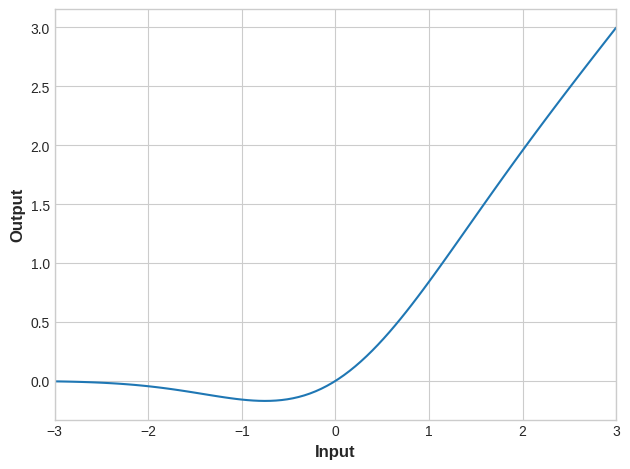

In [ ]:
# YOUR CODE HERE: Experiment with modifying the activation function
activation_layer = layers.Activation('gelu')

x = tf.linspace(-3.0, 3.0, 100)
y = activation_layer(x) # once created, a layer is callable just like a function

plt.figure(dpi=100)
plt.plot(x, y)
plt.xlim(-3, 3)
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

---
# Lab Exercise 3. *Stochastic Gradient Descent*

In this exercise we are going train a neural network and then explore the effect of the learning rate and batch size on learning.

As you learned in class, for computationally efficient training of neural networks, it is important to transform both the features and the target so that all variables are on a comparable scale. We already scaled our features up front in our Pre-processing Pipeline. Now we need to transform our target.



In [ ]:
# make back-up copy of original train target and validation
y_train_orig = y_train 
y_test_orig = y_test 

#Log transform target instead of standardizing
y_train = np.log(y_train) 
y_test = np.log(y_test) 

input_shape = [Xprocessed_train_df.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [27]


Run the next cell to define the network we'll use for this exercise. We will use a network with 128 nodes in the first two hidden layers with ReLU activation and 64 nodes in a third hidden layer with ReLU activation.

In [ ]:
#from tensorflow import keras
#from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

## 1) Add Loss Function and Optimizer

Before training the network we need to define the loss and optimizer we'll use. Using the model's `compile` method, add the Adam optimizer and MAE loss.

In [ ]:
# YOUR CODE HERE: Fill in the blanks
model.compile(
    optimizer = 'adam', # declare optimizer
    loss = 'mae', # declare loss function
)

## 2) Train Model

Once you've defined the model and compiled it with a loss and optimizer you're ready for training. Train the network for 200 epochs with a batch size of 128. The input data is `X` with target `y`.

In [ ]:
# YOUR CODE HERE: Fill in the blanks
history = model.fit(
    Xprocessed_train_df,y_train, # training data
    batch_size = 128, # batch size
    epochs = 200, # epochs
    verbose = 1, # print output
)

Epoch 1/200
50/50 [==============================] - 2s 6ms/step - loss: 2.8949
Epoch 2/200
50/50 [==============================] - 0s 6ms/step - loss: 0.5248
Epoch 3/200
50/50 [==============================] - 0s 6ms/step - loss: 0.4410
Epoch 4/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4326
Epoch 5/200
50/50 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 6/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4207
Epoch 7/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4252
Epoch 8/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4213
Epoch 9/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4170
Epoch 10/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4231
Epoch 11/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4216
Epoch 12/200
50/50 [==============================] - 0s 4ms/step - loss: 0.4229
Epoch 13/200
50/50 [=================

## 3) Evaluate Training

Now we want to look at the loss curves and evaluate the training. Run the cell below to get a plot of the training loss.

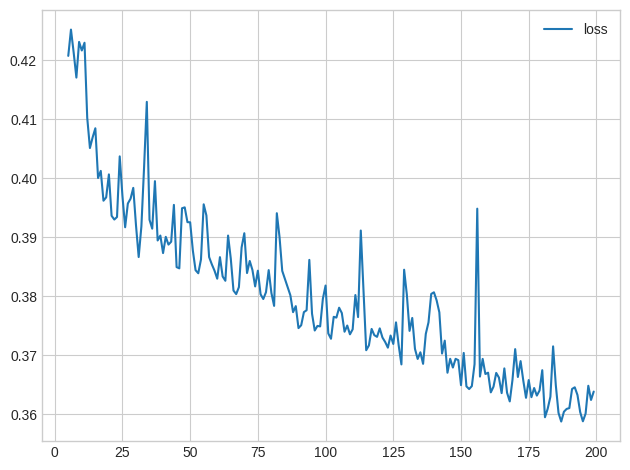

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();

### Q: *If you trained the model longer, would you expect the loss to decrease further?* 

Please write your answer in the empty cell below.



Answer: I think yes but sooner it will plateau out after some time as with the given deep nearal network structure , there is a limit to which it can explain. AFter some time the validation mae will increase like we learned in ML. 


## 4) Explore Learning Rate and Batch Size

With the learning rate and the batch size, you have some control over:
- How long it takes to train a model
- How noisy the learning curves are
- How small the loss becomes

To get a better understanding of these two parameters, we'll look at the linear model, our simplest neural network. Having only a single weight and a bias, it's easier to see what effect a change of parameter has.

The next cell will generate an animation like the one you saw in class. 

In [ ]:
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#from matplotlib import animation

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


def animate_sgd(num_examples, batch_size, steps, learning_rate,
                true_w=3.0, true_b=2.0, seed=0):
    # Define model
    class Model(object):
        def __init__(self, w_init=-1.0, b_init=-1.0):
            self.W = tf.Variable(w_init)
            self.b = tf.Variable(b_init)

        def __call__(self, x):
            return self.W * x + self.b
            
    def loss(target_y, predicted_y):
        return tf.reduce_mean(tf.square(target_y - predicted_y))

    def train(model, inputs, outputs, learning_rate):
        with tf.GradientTape() as t:
            current_loss = loss(outputs, model(inputs))
            dW, db = t.gradient(current_loss, [model.W, model.b])
            model.W.assign_sub(learning_rate * dW)
            model.b.assign_sub(learning_rate * db)
    # Data
    inputs  = tf.random.normal(shape=[num_examples], seed=seed)
    noise   = tf.random.normal(shape=[num_examples], seed=seed+1)
    outputs = inputs * true_w + true_b + noise
    ds = (tf.data.Dataset
          .from_tensor_slices((inputs, outputs))
          .shuffle(1000, seed=seed)
          .batch(batch_size)
          .repeat())
    ds = iter(ds)
    model = Model()
    # Collect the history of W-values and b-values to plot later
    Ws, bs, xs, ys, ls = [], [], [], [], []
    # Construct plot
    fig = plt.figure(dpi=100, figsize=(8, 3))

    # Regression Line
    ax1 = fig.add_subplot(131)
    ax1.set_title("Fitted Line")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_xlim(-3, 2.5)
    ax1.set_ylim(-8, 11)
    p10, = ax1.plot(inputs, outputs, 'r.', alpha=0.1) # full dataset
    p11, = ax1.plot([], [], 'C3.') # batch, color Red
    p12, = ax1.plot([], [], 'k') # fitted line, color Black

    # Loss
    ax2 = fig.add_subplot(132)
    ax2.set_title("Training Loss")
    ax2.set_xlabel("Batches Seen")
    ax2.set_xlim(0, steps)
    ax2.set_ylim(0, 40)
    p20, = ax2.plot([], [], 'C0') # color Blue

    # Weights
    ax3 = fig.add_subplot(133)
    ax3.set_title("Weights")
    ax3.set_xlabel("Batches Seen")
    ax3.set_xlim(0, steps)     # 
    ax3.set_ylim(-2, 4)
    ax3.plot(range(steps), [true_w for _ in range(steps)], 'C5--')
    ax3.plot(range(steps), [true_b for _ in range(steps)], 'C8--')
    p30, = ax3.plot([], [], 'C5') # W color Brown
    p30.set_label('W')
    p31, = ax3.plot([], [], 'C8') # b color Green
    p31.set_label('b')
    ax3.legend()

    fig.tight_layout()

    def init():
        return [p10]

    def update(epoch):
        x, y = next(ds)
        y_pred = model(x)
        current_loss = loss(y, y_pred)
          
        Ws.append(model.W.numpy())
        bs.append(model.b.numpy())
        xs.append(x.numpy())
        ys.append(y_pred.numpy())
        ls.append(current_loss.numpy())
        p11.set_data(x.numpy(), y.numpy())
        inputs = tf.linspace(-3.0, 2.5, 30)
        p12.set_data(inputs, Ws[-1]*inputs + bs[-1])
        p20.set_data(range(epoch), ls)
        p30.set_data(range(epoch), Ws)
        p31.set_data(range(epoch), bs)

        train(model, x, y, learning_rate=learning_rate)
        #   print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        #         (epoch, Ws[-1], bs[-1], current_loss))
        
        return p11, p12, p20

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=range(1, steps),
        init_func=init,
        blit=True,
        interval=100,
    )
    plt.close()
    return ani



<ipython-input-31-5145a1510aa3>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In the next cell, experiment with changing the values for `learning_rate`, `batch_size`, and `num_examples` (how many data points) and then re-run the cell. (It may take a moment or two, each time.) 

Try the following combinations, or try some of your own:

| `learning_rate` | `batch_size` | `num_examples` |
|-----------------|--------------|----------------|
| 0.05            | 32           | 256            |
| 0.05            | 2            | 256            |
| 0.05            | 128          | 256            |
| 0.02            | 32           | 256            |
| 0.2             | 32           | 256            |
| 1.0             | 32           | 256            |
| 0.9             | 4096         | 8192           |
| 0.99            | 4096         | 8192           |

In [ ]:
# YOUR CODE HERE: Experiment with different values for learning rate, batch size and number of examples
learning_rate = 0.05
batch_size = 256
num_examples = 2500

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these too, if you like...
    steps=50, # total training steps (batches seen)
    true_w=3.0, # the slope of the data
    true_b=2.0, # the bias of the data
)

In [ ]:
# YOUR CODE HERE: Experiment with different values for learning rate, batch size and number of examples
learning_rate = 0.05
batch_size = 256
num_examples = 256

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these too, if you like...
    steps=50, # total training steps (batches seen)
    true_w=3.0, # the slope of the data
    true_b=2.0, # the bias of the data
)


### Q: *What effect did changing the parameters have?* 

Write your answer in the empty cell below.

Answer:
The learning rate keeps jumping the line too much and keeps shifting too much while learning. 
The batch size should help in reducing the time and the errors should drop more faster with higher batch sizes. 
The number of examples represents the total samples taken. The losses are reducing in both cases but since more data points are there, the training loss are more smooth as it learns a lot from a lot of data. 

